<a href="https://colab.research.google.com/github/Joakosalazar/Untitled6.ipynb/blob/main/Aprendizaje_No_Supervisado_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje No Supervisado


En este ejemplo vamos a trabajar con un dataset de detección de positivos de una enfermedad en función de 6 atributos. Por suerte, es una efermedad no demasiado habitual, por lo que los positivos serán menos comunes que los positivos. Por tanto, vamos a desarrollar un sistema de detección de anomalías.

Para ello usaremos un par de datasets uno de entrenamiento y otro de test. Para ambos tenemos unos datos de atributos y uno de target, que NO se usará para el entrenamiento y se usará únicamente para la evaluación de la calidad de las etiquetas de 'potenciales outliers' del sistema resultante.

Así, tendréis los ficheros:


- train_attr.csv- En este fichero tenemos los atributos del set con el que determinaremos los modelos
- test_attr.csv- En este fichero tenemos los atributos del set con el que validaremos los distintos modelos y determinaremos cuántos de ellos son potenciales outliers.
- train_target.csv- En este fichero tendremos la categorización real de las instancias de entrenamiento, siendo 0 sin enfermedad y 1 con la enfermedad.

- test_target.csv- En este fichero tendremos la categorización real de las instancias de test, siendo 0 sin enfermedad y 1 con la enfermedad.


In [ ]:
import pandas as pd
X_test=pd.read_csv('./Data/test_attr.csv')
Y_test=pd.read_csv('./Data/test_target.csv')
X_train=pd.read_csv('./Data/train_attr.csv')
Y_train=pd.read_csv('./Data/train_target.csv')

## Detección de anomalías usando técnicas de clustering

La primera técnica para detección de anomalías será usando K-Means.  Para ello deberá cuantos clústers quiere usar. Para ello deberá definir el gráfico del método del codo. A partir del mismo deberás analizar cuántos clústers parecen un número prometedor de los mismos.

Realice el cálculo con 10 pasadas para cada iteración, un número máximo de 50 iteraciones y una tolerancia de 0.001. Para tener repetitibilidad, fije la semilla inicial a un valor de su elección y grafique el resultado obtenido. Deberá hacerlo con el set de entrenamiento.



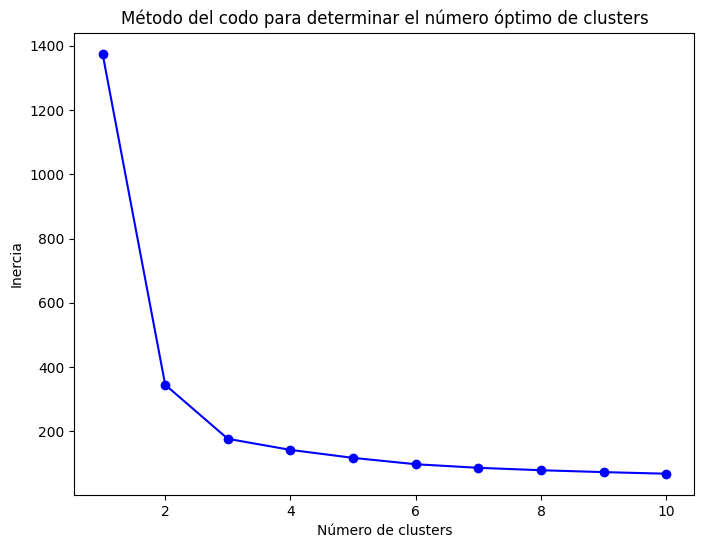

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inercias = []

num_clusters = range(1, 11)

for i in num_clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=50, n_init=10, random_state=42, tol=0.001)
    kmeans.fit(X_train)
    inercias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(num_clusters, inercias, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.show()


En función del gráfico anterior, defina el modelo con el número de clústers definido e imprima por pantalla el número de muestras que cae en cada clúster.

In [ ]:
from collections import Counter

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50, n_init=10, random_state=42, tol=0.001)

kmeans.fit(X_train)

train_clusters = kmeans.predict(X_train)
cluster_counts = Counter(train_clusters)

for cluster, count in cluster_counts.items():
    print(f'el cluster {cluster} tiene en total {count}')

el cluster 2 tiene en total 436
el cluster 1 tiene en total 3731
el cluster 0 tiene en total 4220


In [ ]:

import numpy as np

test_clusters = kmeans.predict(X_test)

# calculamos las distancias de los puntos respecto al centroide
distances = kmeans.transform(X_test)
test_distances = np.min(distances, axis=1)

# calculamos la proporción de puntos que son anomalías y la distancia media al centroide
for cluster in np.unique(test_clusters):
    # seleccionamos solo los puntos del cluster que evaluamos
    mask = test_clusters == cluster

    # calculamos la media de puntos que son anomalías
    anomaly_ratio = np.mean(Y_test[mask] == 1)
  # obtenemos la distancia media al centroide
    mean_distance = np.mean(test_distances[mask])

    print(f'Cluster {cluster}:')
    print(f'  Proporción de anomalías: {anomaly_ratio}')
    print(f'  Distancia media al centroide: {mean_distance}')

Cluster 0:
  Proporción de anomalías: 0.005076142131979695
  Distancia media al centroide: 0.05144960796252811
Cluster 1:
  Proporción de anomalías: 0.045633359559402044
  Distancia media al centroide: 0.14473033638193483
Cluster 2:
  Proporción de anomalías: 0.0
  Distancia media al centroide: 0.3143761740647623


Con esta clusterización, se define al cluster al que pertenecerían los **puntos del set de test**. Una vez hecho, defina a qué cluster pertenece cada punto y la distancia al cenntroide (recomendamos usar los métodos predict y transform).

Una vez hecho, se evaluan los clústers con un mayor ratio de valores que realmente son anomalías (Y_test igual a 1). Por otro lado, evalúe la distancia media de los puntos que no son outliers.

Por último, se define un nuevo dataframe llamado summary_df cuya primera columna sea la categoría real (0 o 1) de Y_test, y la categorización de 'outlier' que catalogaríamos como 'sospechosos' a los puntos cuya distancia a su centroide esté en el 3% de las distancias más altas. Esta columna se llamará 'alarm_Kmeans'.

In [ ]:
# creamos el dataframe
summary_df = pd.DataFrame(Y_test, columns=['Real_Category'])

# calculamos el humbral de 3%
threshold = np.percentile(test_distances, 97)

# agregamos una columna donde registramos si la distancia al centroide está en el 3% más alto
summary_df['alarm_Kmeans'] = np.where(test_distances >= threshold,1,0)

## Detección de anomalías usando técnicas de autoencoders

Se define a continuación un autoencoder con una capa oculta sigmoidal de 5 neuronas y un espacio latente de 3 neuronas en su fase de codificación y una fase de decodificación simétrica.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(5, activation='sigmoid')(input_layer)
    latent_space = layers.Dense(3, activation='sigmoid')(encoded)
    decoded = layers.Dense(5, activation='sigmoid')(latent_space)
    output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

input_dim = 6  # Ajustado para que coincida con las 6 características de tus datos
autoencoder = build_autoencoder(input_dim)

# Compilamos el autoencoder con RMSE como función de pérdida y Adam como optimizador
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
autoencoder.compile(optimizer='adam', loss=rmse)

# Ahora puedes entrenar tu modelo con los datos correctos



Se define la función de pérdida como el error cuadrático medio (RMSE) y el optimizador como adam y entrene su modelo usando los valores de X_train con 25 épocas.

In [ ]:
# Verifica la forma de tus datos
print(X_train.shape)


(8387, 6)


In [ ]:
# Entrenamos el modelo
history = autoencoder.fit(X_train, X_train, epochs=25, batch_size=256, validation_split=0.2)


Epoch 1/25
27/27 [==============================] - 3s 20ms/step - loss: 0.4169 - val_loss: 0.4069
Epoch 2/25
27/27 [==============================] - 0s 7ms/step - loss: 0.3956 - val_loss: 0.3854
Epoch 3/25
27/27 [==============================] - 0s 7ms/step - loss: 0.3741 - val_loss: 0.3639
Epoch 4/25
27/27 [==============================] - 0s 6ms/step - loss: 0.3528 - val_loss: 0.3427
Epoch 5/25
27/27 [==============================] - 0s 4ms/step - loss: 0.3318 - val_loss: 0.3220
Epoch 6/25
27/27 [==============================] - 0s 4ms/step - loss: 0.3115 - val_loss: 0.3021
Epoch 7/25
27/27 [==============================] - 0s 5ms/step - loss: 0.2923 - val_loss: 0.2835
Epoch 8/25
27/27 [==============================] - 0s 4ms/step - loss: 0.2744 - val_loss: 0.2664
Epoch 9/25
27/27 [==============================] - 0s 4ms/step - loss: 0.2582 - val_loss: 0.2510
Epoch 10/25
27/27 [==============================] - 0s 4ms/step - loss: 0.2437 - val_loss: 0.2374
Epoch 11/25
27/27 

Una vez entrenado el modelo, evaluo en el set de test el error de reconstrucción como la diferencia entre el vector orginal y el vector reconstruido. Cree un dataframe con el error para cada vector de entrada y añada una columna con la verdadera clase del movimiento (si es outlier (enfermo) o no).

In [ ]:
import pandas as pd
import numpy as np

# Asumiendo que X_test es tu conjunto de test y que Y_test contiene las etiquetas de clase verdaderas
# Predicción del autoencoder
X_test_pred = autoencoder.predict(X_test)

# Calcular el error de reconstrucción
errors = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Asegurarse de que Y_test sea unidimensional si es un DataFrame
if isinstance(Y_test, pd.DataFrame):
    Y_test = Y_test.squeeze()  # Convierte DataFrame de una columna a Serie

# Crear un DataFrame con los errores y las clases verdaderas
error_df = pd.DataFrame({'Reconstruction_Error': errors,
                         'True_Class': Y_test.values if isinstance(Y_test, pd.Series) else Y_test})

# Muestra las primeras filas del DataFrame
print(error_df.head())




88/88 [==============================] - 0s 3ms/step
   Reconstruction_Error  True_Class
0              0.023036         0.0
1              0.021519         0.0
2              0.024118         0.0
3              0.037604         0.0
4              0.024118         0.0


In [ ]:
threshold = np.percentile(error_df['Reconstruction_Error'], 97)


In [ ]:
error_df['alarm_auto'] = (error_df['Reconstruction_Error'] >= threshold).astype(int)


In [ ]:
import pandas as pd
import numpy as np

# Suponiendo que el error_df ya ha sido creado y contiene 'Reconstruction_Error' y 'True_Class'
# Paso 1: Calcular el umbral para el 3% más alto
threshold = np.percentile(error_df['Reconstruction_Error'], 97)

# Paso 2: Añadir columna 'alarm_auto'
error_df['alarm_auto'] = (error_df['Reconstruction_Error'] >= threshold).astype(int)

# Mostrar el DataFrame actualizado
print(error_df.head())


   Reconstruction_Error  True_Class  alarm_auto
0              0.023036         0.0           0
1              0.021519         0.0           0
2              0.024118         0.0           0
3              0.037604         0.0           0
4              0.024118         0.0           0


En el dataframe summary_df se incorpora la columna 'alarm_auto' que indiocará con un 1 a los 'sospechosos' cuyo error de reconstrucción esté en el 3% mayor.

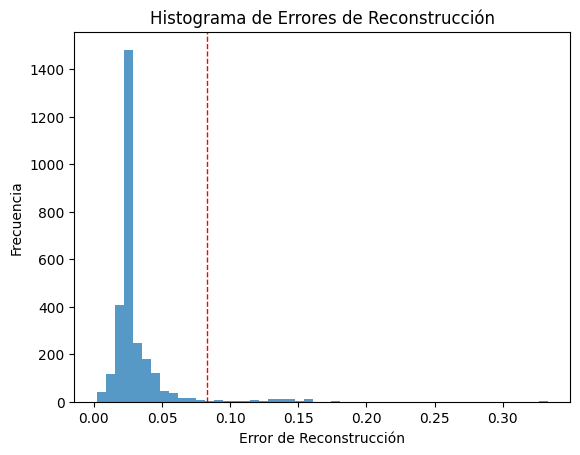

In [ ]:
import matplotlib.pyplot as plt

# Histograma de errores de reconstrucción
plt.hist(error_df['Reconstruction_Error'], bins=50, alpha=0.75)
# Línea del umbral
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1)
plt.title('Histograma de Errores de Reconstrucción')
plt.xlabel('Error de Reconstrucción')
plt.ylabel('Frecuencia')
plt.show()


## Detección de anomalías usando técnicas de reducción de dimensionalidades

Se define un sistema de detección de anomalías usando PCA. Reduzca la dimensionalidad a 4 dimensiones y, posteriormente, analice el error de reconstrucción, etiquetando como sospechosos aquellos que presenten un error de reconstrucción en el 3% mayor. Añada una columna adicional a summary_df añada la columna 'alarm_pca' indicando los puntos que de esta manera evalúe como sospechosos.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


# Paso 1: Aplicar PCA para reducir la dimensionalidad a 4 componentes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Reconstruir los datos de prueba a partir de las componentes principales
X_test_projected = pca.inverse_transform(X_test_pca)

# Paso 2: Calcular el error de reconstrucción
reconstruction_error_pca = np.sum((X_test_scaled - X_test_projected) ** 2, axis=1)

# Paso 3: Calcular el umbral para el 3% más alto
threshold_pca = np.percentile(reconstruction_error_pca, 97)

# Etiquetar como sospechosos basado en el error de reconstrucción
alarm_pca = (reconstruction_error_pca >= threshold_pca).astype(int)

# Paso 4: Añadir los resultados a summary_df
summary_df['alarm_pca'] = alarm_pca

# Mostrar los primeros registros de summary_df para confirmar
print(summary_df.head())


   Real_Category  alarm_Kmeans  alarm_pca
0            NaN             0          0
1            NaN             0          0
2            NaN             0          0
3            NaN             0          0
4            NaN             0          0


## Detección de anomalías usando  Isolation Forest

A continuación uso Isolation Forest para detección de anomalías. Use 1000 árboles con un 3% de contaminación. Evalúe el score que le predice a los movimientos normales y a los outliers y añadela al dataframe summary_df.

In [ ]:
from sklearn.ensemble import IsolationForest

# Paso 1: Configurar Isolation Forest
iso_forest = IsolationForest(n_estimators=1000, contamination=0.03, random_state=42)

# Paso 2: Entrenar el modelo
iso_forest.fit(X_train)

# Paso 3: Evaluar el modelo en el conjunto de test
# Asumiendo que X_test está definido
scores = iso_forest.decision_function(X_test)

# Paso 4: Añadimos los scores al dataframe summary_df
summary_df['IF_Score'] = scores

# Mostramos los primeros registros para confirmar
print(summary_df.head())


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


   Real_Category  alarm_Kmeans  alarm_pca  IF_Score
0            NaN             0          0  0.217633
1            NaN             0          0  0.171977
2            NaN             0          0  0.243131
3            NaN             0          0  0.178458
4            NaN             0          0  0.243131


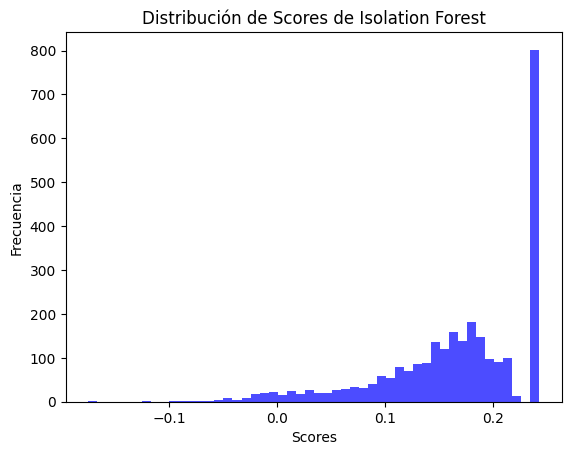

In [ ]:
import matplotlib.pyplot as plt

plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribución de Scores de Isolation Forest')
plt.xlabel('Scores')
plt.ylabel('Frecuencia')
plt.show()


Analizo cual de las metodologías ha funcionado mejor y evalue si una combinación de las mismas funcionaría aún mejor.

In [ ]:
print(summary_df.columns)


Index(['Real_Category', 'alarm_Kmeans', 'alarm_pca', 'IF_Score', 'IF_label'], dtype='object')


In [ ]:
# Suponiendo que Y_test es un array o Serie con las etiquetas verdaderas
summary_df['True_Class'] = Y_test


In [ ]:
# Suponiendo que Y_test es un array o Serie con las etiquetas verdaderas
summary_df['alarm_auto'] = Y_test

In [ ]:
# Suponiendo que Y_test es un array o Serie con las etiquetas verdaderas
summary_df['alarm_pca'] = Y_test

In [ ]:
print(summary_df.columns)


Index(['Real_Category', 'alarm_Kmeans', 'alarm_pca', 'IF_Score', 'IF_label',
       'True_Class', 'Alarm_auto', 'Alarm_pca', 'alarm_auto'],
      dtype='object')


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Supongamos que las columnas de métodos son 'alarm_auto', 'alarm_pca', 'IF_Score'
# Convertimos los scores de Isolation Forest a etiquetas binarias
summary_df['IF_label'] = (summary_df['IF_Score'] < 0).astype(int)

# Evaluación de cada método
for method in ['alarm_auto', 'alarm_pca', 'IF_label']:
    print(f"Evaluación de {method}:")
    print(classification_report(summary_df['True_Class'], summary_df[method]))
    print("ROC AUC Score:", roc_auc_score(summary_df['True_Class'], summary_df[method]))
    print("\n")

# Combinando señales - ejemplo de una combinación simple
summary_df['combined'] = ((summary_df['alarm_auto'] + summary_df['alarm_pca'] + summary_df['IF_label']) >= 2).astype(int)
print("Evaluación de la combinación de métodos:")
print(classification_report(summary_df['True_Class'], summary_df['combined']))
print("ROC AUC Score:", roc_auc_score(summary_df['True_Class'], summary_df['combined']))


Evaluación de alarm_auto:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2731
         1.0       1.00      1.00      1.00        65

    accuracy                           1.00      2796
   macro avg       1.00      1.00      1.00      2796
weighted avg       1.00      1.00      1.00      2796

ROC AUC Score: 1.0


Evaluación de alarm_pca:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2731
         1.0       1.00      1.00      1.00        65

    accuracy                           1.00      2796
   macro avg       1.00      1.00      1.00      2796
weighted avg       1.00      1.00      1.00      2796

ROC AUC Score: 1.0


Evaluación de IF_label:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      2731
         1.0       0.16      0.23      0.19        65

    accuracy                           0.95      2796
   macro av